In [2]:
!pip install torch_geometric

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

import torch
from torch_geometric.data import Data, Dataset

import matplotlib.pyplot as plt
import networkx as nx

import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00


In [3]:
# Load data
quant_metadata = pd.read_excel("TRAIN_QUANTITATIVE_METADATA.xlsx")
cat_metadata = pd.read_excel("TRAIN_CATEGORICAL_METADATA.xlsx")

# Separate participant IDs
participant_ids_quant = quant_metadata["participant_id"]
participant_ids_cat = cat_metadata["participant_id"]

# Drop participant ID columns
quant_metadata = quant_metadata.drop(columns=["participant_id"])
cat_metadata = cat_metadata.drop(columns=["participant_id"])

## 1️⃣ Preprocess Quantitative Features ##
imputer = SimpleImputer(strategy="median")  # Impute missing values
quant_metadata_imputed = imputer.fit_transform(quant_metadata)

scaler = StandardScaler()  # Normalize numerical data
quant_metadata_scaled = scaler.fit_transform(quant_metadata_imputed)

quant_metadata_df = pd.DataFrame(quant_metadata_scaled, columns=quant_metadata.columns)
quant_metadata_df.insert(0, "participant_id", participant_ids_quant)

## 2️⃣ Preprocess Categorical Features ##
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")  # Corrected argument
cat_metadata_encoded = encoder.fit_transform(cat_metadata)

cat_metadata_df = pd.DataFrame(cat_metadata_encoded, columns=encoder.get_feature_names_out(cat_metadata.columns))
cat_metadata_df.insert(0, "participant_id", participant_ids_cat)

## 3️⃣ Merge Processed Data ##
demographic_data_processed = quant_metadata_df.merge(cat_metadata_df, on="participant_id")

# Save or return the final processed DataFrame
demographic_data_processed.to_csv("processed_demographic_data.csv", index=False)

In [4]:
# Load dataset (update path if needed)
df = pd.read_csv("/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")  # Assuming your file is a CSV

# Extract participant IDs and connectivity values
participant_ids = df["participant_id"].values
connectivity_values = df.drop(columns=["participant_id"]).values  # Remove ID column

num_regions = 199  # Number of brain regions (assuming a 199x199 matrix)

In [5]:
def reconstruct_adjacency(flat_connectivity, num_regions=199, threshold=None):
    """Reconstructs a symmetric adjacency matrix from a flattened upper-triangle format."""
    adj_matrix = np.zeros((num_regions, num_regions))

    # Get the upper triangular indices (excluding diagonal)
    triu_indices = np.triu_indices(num_regions, k=0)  # (row_indices, col_indices)

    # Fill the upper triangular part
    adj_matrix[triu_indices] = flat_connectivity

    # Make symmetric by copying the upper triangle to the lower triangle
    adj_matrix += adj_matrix.T

    # Apply thresholding if specified
    if threshold is not None:
        adj_matrix[np.abs(adj_matrix) < threshold] = 0  # Remove weak edges

    return adj_matrix

In [6]:
graph_list = []
for i, row in enumerate(connectivity_values):
    adj_matrix = reconstruct_adjacency(row, threshold=0.025)  # Adjust threshold as needed

    # Convert adjacency matrix to edge index format
    edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
    edge_attr = torch.tensor(adj_matrix[edge_index[0], edge_index[1]], dtype=torch.float)

    # Debug: Print edge index stats
    print(f"Graph {i}: Edge index shape {edge_index.shape}, Edge count: {edge_index.shape[1]}")
    print(f"Sample edges:\n {edge_index[:, :5]}")  # Print first 5 edges

    # Get demographic features for this participant
    participant_id = participant_ids[i]  # Assuming participant_ids aligns with connectivity_values
    demo_features = demographic_data_processed[
        demographic_data_processed["participant_id"] == participant_id
    ].drop(columns=["participant_id"]).values  # Extract feature values

    # Repeat demographic features for each brain region
    num_nodes = adj_matrix.shape[0]  # Should be 199 nodes
    x = np.tile(demo_features, (num_nodes, 1))  # Now shape is (199, num_features)

    # Convert to tensor
    x = torch.tensor(x, dtype=torch.float)

    # Debug: Print fixed shape
    print(f"Graph {i}: x shape after fix {x.shape}")  # Should be (199, num_features)

    # Create PyG graph object
    graph = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor([1 if "ADHD" in participant_ids[i] else 0], dtype=torch.long)
    )

    graph_list.append(graph)

# Debug first graph
print(graph_list[0])

Graph 0: Edge index shape torch.Size([2, 20199]), Edge count: 20199
Sample edges:
 tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 4, 5]])
Graph 0: x shape after fix torch.Size([199, 84])
Graph 1: Edge index shape torch.Size([2, 22910]), Edge count: 22910
Sample edges:
 tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4]])
Graph 1: x shape after fix torch.Size([199, 84])
Graph 2: Edge index shape torch.Size([2, 20149]), Edge count: 20149
Sample edges:
 tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4]])
Graph 2: x shape after fix torch.Size([199, 84])
Graph 3: Edge index shape torch.Size([2, 20256]), Edge count: 20256
Sample edges:
 tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4]])
Graph 3: x shape after fix torch.Size([199, 84])
Graph 4: Edge index shape torch.Size([2, 21076]), Edge count: 21076
Sample edges:
 tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4]])
Graph 4: x shape after fix torch.Size([199, 84])
Graph 5: Edge index shape torch.Size([2, 20970]), Edge count: 20970
Sample edges:
 te

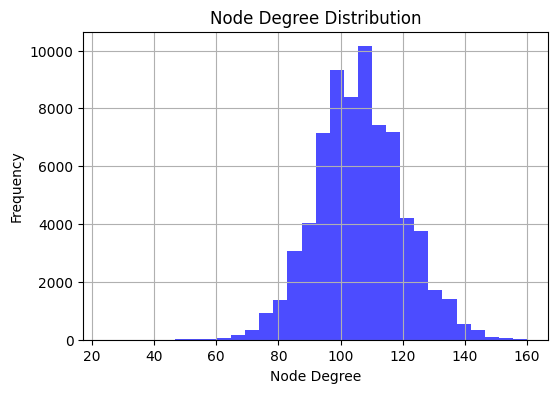

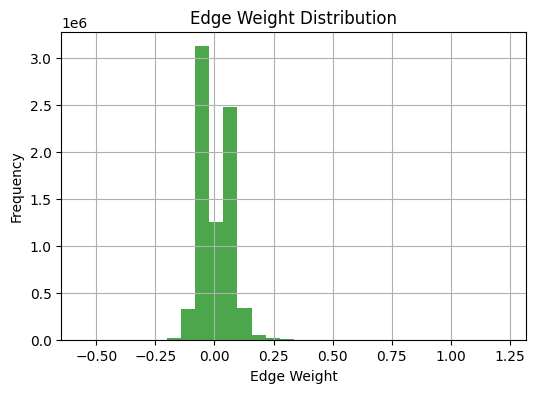

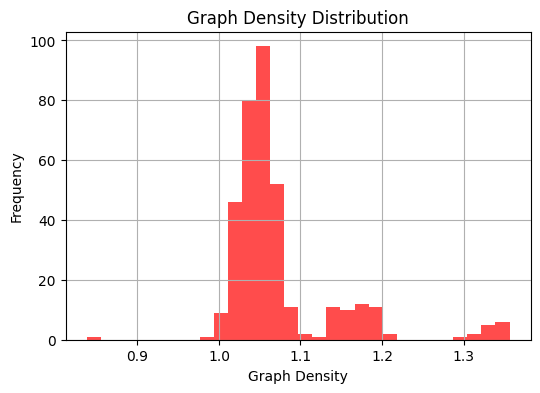

In [7]:
# Extract graph properties
node_degrees = []
edge_weights = []
graph_densities = []

for graph in graph_list:
    # Compute node degrees
    degrees = torch.bincount(graph.edge_index[0], minlength=graph.x.shape[0]).numpy()
    node_degrees.extend(degrees)

    # Store edge weights
    edge_weights.extend(graph.edge_attr.numpy())

    # Compute graph density safely
    num_nodes = graph.x.shape[0]
    num_edges = graph.edge_index.shape[1]

    if num_nodes > 1:
        density = (2 * num_edges) / (num_nodes * (num_nodes - 1))
    else:
        density = 0  # Avoid division by zero for isolated nodes

    graph_densities.append(density)

# Plot Node Degree Distribution
plt.figure(figsize=(6, 4))
plt.hist(node_degrees, bins=30, color='blue', alpha=0.7)
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.title("Node Degree Distribution")
plt.grid(True)
plt.show()

# Plot Edge Weight Distribution
plt.figure(figsize=(6, 4))
plt.hist(edge_weights, bins=30, color='green', alpha=0.7)
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.title("Edge Weight Distribution")
plt.grid(True)
plt.show()

# Plot Graph Density Distribution
plt.figure(figsize=(6, 4))
plt.hist(graph_densities, bins=30, color='red', alpha=0.7)
plt.xlabel("Graph Density")
plt.ylabel("Frequency")
plt.title("Graph Density Distribution")
plt.grid(True)
plt.show()

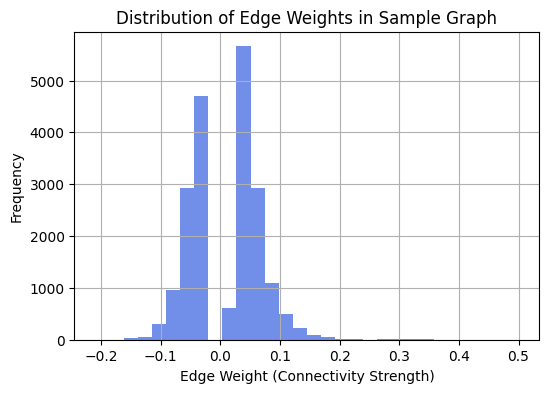

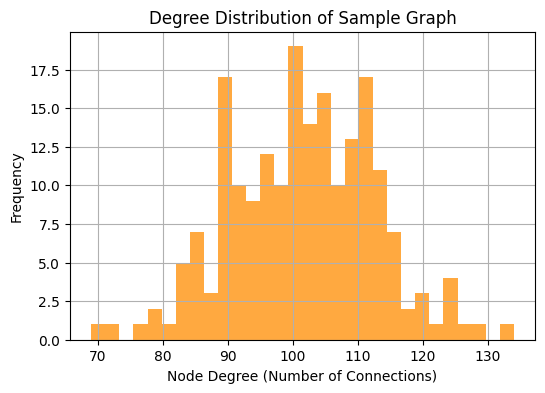

In [8]:
# Select a sample graph
sample_graph = graph_list[0]
weights = sample_graph.edge_attr.numpy()

# 🔹 1️⃣ Histogram of Edge Weights
plt.figure(figsize=(6, 4))
plt.hist(weights, bins=30, color="royalblue", alpha=0.75)
plt.xlabel("Edge Weight (Connectivity Strength)")
plt.ylabel("Frequency")
plt.title("Distribution of Edge Weights in Sample Graph")
plt.grid(True)
plt.show()

# 🔹 2️⃣ Degree Distribution
degrees = np.bincount(sample_graph.edge_index[0].numpy())  # Count connections per node

plt.figure(figsize=(6, 4))
plt.hist(degrees, bins=30, color="darkorange", alpha=0.75)
plt.xlabel("Node Degree (Number of Connections)")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Sample Graph")
plt.grid(True)
plt.show()

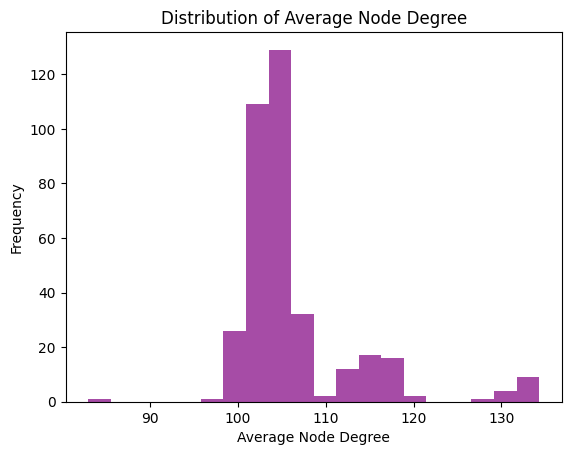

In [9]:
degrees = [graph.edge_index.shape[1] / graph.x.shape[0] for graph in graph_list]
plt.hist(degrees, bins=20, color='purple', alpha=0.7)
plt.xlabel("Average Node Degree")
plt.ylabel("Frequency")
plt.title("Distribution of Average Node Degree")
plt.show()

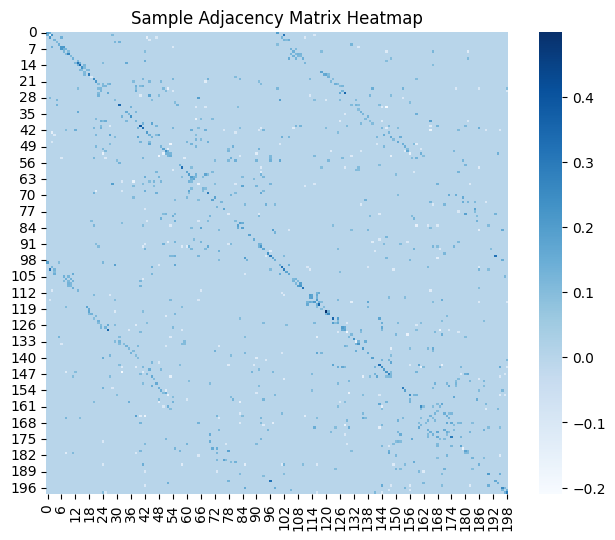

In [10]:
sample_adj = reconstruct_adjacency(connectivity_values[0], threshold=0.1)
plt.figure(figsize=(8, 6))
sns.heatmap(sample_adj, cmap="Blues", square=True, cbar=True)
plt.title("Sample Adjacency Matrix Heatmap")
plt.show()

In [11]:
# Load the ADHD labels from the Excel file
label_df = pd.read_excel("TRAINING_SOLUTIONS.xlsx")

# Ensure column names are as expected
print(label_df.head())  # Check structure

# Convert participant_id to string to ensure consistent formats
label_df["participant_id"] = label_df["participant_id"].astype(str)

  participant_id  ADHD_Outcome  Sex_F
0   UmrK0vMLopoR             1      1
1   CPaeQkhcjg7d             1      0
2   Nb4EetVPm3gs             1      0
3   p4vPhVu91o4b             1      1
4   M09PXs7arQ5E             1      1


In [12]:
# Create lookup dictionaries for ADHD and Sex labels
adhd_labels = dict(zip(label_df["participant_id"], label_df["ADHD_Outcome"]))
sex_labels = dict(zip(label_df["participant_id"], label_df["Sex_F"]))

# Assign both labels to each graph
for i, graph in enumerate(graph_list):
    participant_id = str(participant_ids[i])  # Convert to string for consistency
    if participant_id in adhd_labels and participant_id in sex_labels:
        graph.y = torch.tensor([adhd_labels[participant_id], sex_labels[participant_id]], dtype=torch.float).view(1, 2)
    else:
        print(f"Warning: No label found for {participant_id}")

# Count ADHD cases
adhd_counts = sum(graph.y[0, 0].item() for graph in graph_list)  # ADHD is at index [0, 0]
print(f"Total ADHD cases in dataset: {adhd_counts} / {len(graph_list)}")

# Count Female cases
sex_counts = sum(graph.y[0, 1].item() for graph in graph_list)  # Sex is at index [0, 1]
print(f"Total Fs in dataset: {sex_counts} / {len(graph_list)}")

Total ADHD cases in dataset: 257.0 / 361
Total Fs in dataset: 118.0 / 361


In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_mean_pool

# class GCN(torch.nn.Module):
#     def __init__(self, num_node_features, hidden_dim, num_classes, dropout_rate=0.5):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(num_node_features, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, hidden_dim)  # Keep node embeddings
#         self.fc = torch.nn.Linear(hidden_dim * 2, num_classes)  # Adjust for concatenated features
#         self.dropout = torch.nn.Dropout(dropout_rate)  # Dropout layer

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch  # batch info

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.dropout(x)  # Apply dropout after first layer

#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         x = self.dropout(x)  # Apply dropout after second layer

#         # Aggregate node embeddings using both mean and max pooling
#         x_mean = global_mean_pool(x, batch)  # Mean pooling
#         x_max = global_max_pool(x, batch)  # Max pooling
#         x = torch.cat([x_mean, x_max], dim=1)  # Concatenate pooled features

#         return self.fc(x)  # Outputs [batch_size, num_classes]

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)  # Keep node embeddings
        self.dropout = torch.nn.Dropout(dropout_rate)  # Dropout layer

        # Separate fully connected layers for ADHD and Sex predictions
        self.fc_adhd = torch.nn.Linear(hidden_dim * 2, 1)  # Output 1 neuron (binary classification)
        self.fc_sex = torch.nn.Linear(hidden_dim * 2, 1)   # Output 1 neuron (binary classification)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  # batch info

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after first layer

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after second layer

        # Aggregate node embeddings using both mean and max pooling
        x_mean = global_mean_pool(x, batch)  # Mean pooling
        x_max = global_max_pool(x, batch)  # Max pooling
        x = torch.cat([x_mean, x_max], dim=1)  # Concatenate pooled features

        # Separate outputs for ADHD and Sex
        adhd_out = self.fc_adhd(x)  # ADHD prediction
        sex_out = self.fc_sex(x)    # Sex prediction

        return torch.cat([adhd_out, sex_out], dim=1)  # Keep the same output shape

# Model Instantiation
in_features = graph_list[0].x.shape[1]  # Number of input features per node
hidden_dim = 32  # Hidden layer size
num_classes = 2  # ADHD vs. Non-ADHD

dropout_rate = 0.5  # Ensure dropout is between 0 and 1
model = GCN(in_features, hidden_dim, dropout_rate=dropout_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)  # Increase weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# DataLoader for batching
train_loader = DataLoader(graph_list[:int(len(graph_list) * 0.7)], batch_size=32, shuffle=True)
val_loader = DataLoader(graph_list[int(len(graph_list) * 0.7):int(len(graph_list) * 0.85)], batch_size=32)
test_loader = DataLoader(graph_list[int(len(graph_list) * 0.85):], batch_size=32)

In [14]:
# def evaluate(model, val_loader):
#     model.eval()
#     correct_adhd = 0
#     correct_sex = 0
#     total = 0

#     with torch.no_grad():
#         for data in val_loader:
#             out = model(data)  # Raw logits

#             pred_adhd = (torch.sigmoid(out[:, 0]) > 0.5).long()  # Convert logits to binary predictions
#             pred_sex = (torch.sigmoid(out[:, 1]) > 0.5).long()

#             correct_adhd += (pred_adhd == data.y[:, 0]).sum().item()
#             correct_sex += (pred_sex == data.y[:, 1]).sum().item()

#             total += data.y.size(0)

#     adhd_acc = correct_adhd / total
#     sex_acc = correct_sex / total

#     print(f"Validation ADHD Acc: {adhd_acc:.4f}, Sex Acc: {sex_acc:.4f}")
#     return (adhd_acc + sex_acc) / 2  # Return average accuracy

from sklearn.metrics import f1_score

def evaluate(model, val_loader):
    model.eval()
    correct_adhd = 0
    correct_sex = 0
    total = 0

    all_preds_adhd, all_targets_adhd = [], []
    all_preds_sex, all_targets_sex = [], []

    with torch.no_grad():
        for data in val_loader:
            out = model(data)  # Raw logits

            pred_adhd = (torch.sigmoid(out[:, 0]) > 0.5).long()  # Convert logits to binary predictions
            pred_sex = (torch.sigmoid(out[:, 1]) > 0.5).long()

            correct_adhd += (pred_adhd == data.y[:, 0]).sum().item()
            correct_sex += (pred_sex == data.y[:, 1]).sum().item()

            total += data.y.size(0)

            # Store predictions and ground truth for F1 score
            all_preds_adhd.extend(pred_adhd.cpu().numpy())
            all_targets_adhd.extend(data.y[:, 0].cpu().numpy())

            all_preds_sex.extend(pred_sex.cpu().numpy())
            all_targets_sex.extend(data.y[:, 1].cpu().numpy())

    adhd_acc = correct_adhd / total
    sex_acc = correct_sex / total

    # Compute F1 scores
    f1_adhd = f1_score(all_targets_adhd, all_preds_adhd, average="binary")
    f1_sex = f1_score(all_targets_sex, all_preds_sex, average="binary")

    print(f"Validation ADHD Acc: {adhd_acc:.4f}, Sex Acc: {sex_acc:.4f}")
    print(f"Validation F1 (ADHD): {f1_adhd:.4f}, F1 (Sex): {f1_sex:.4f}")

    return (f1_adhd + f1_sex) / 2  # Return average F1 score

In [15]:
# Calculate sex label imbalance
num_females = sum(graph.y[0, 1].item() for graph in graph_list)
num_males = len(graph_list) - num_females
sex_weight = torch.tensor([num_males / num_females])  # Inverse ratio to balance classes

# ✅ Define separate loss functions
criterion_adhd = torch.nn.CrossEntropyLoss()  # ADHD uses standard classification loss
criterion_sex = torch.nn.BCEWithLogitsLoss(pos_weight=sex_weight)  # Sex gets balanced loss

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, patience=10):
    model.train()  # Set to training mode
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        total_loss = 0
        correct_adhd, correct_sex, total = 0, 0, 0

        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)  # Forward pass

            # ✅ Use different loss functions
            loss_adhd = criterion_adhd(out[:, 0], data.y[:, 0])  # ADHD classification
            loss_sex = criterion_sex(out[:, 1], data.y[:, 1].float())  # Sex classification with BCE loss

            loss = (1.0 * loss_adhd) + (0.7 * loss_sex)  # Shift priority to ADHD

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()

            correct_adhd += (out[:, 0].argmax(dim=-1) == data.y[:, 0]).sum().item()
            correct_sex += ((out[:, 1] > 0.5) == data.y[:, 1]).sum().item()  # ✅ Convert logits to binary
            total += data.y.size(0)

        adhd_acc = correct_adhd / total
        sex_acc = correct_sex / total
        val_acc = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, ADHD Acc: {adhd_acc:.4f}, Sex Acc: {sex_acc:.4f}, Val Accuracy: {val_acc:.4f}")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0  # Reset patience counter when validation improves
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break  # Stop training

# Train the model with early stopping
train(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, patience=5)

val_f1 = evaluate(model, val_loader)
print(f"Validation F1 Score: {val_f1:.4f}")

test_f1 = evaluate(model, test_loader)
print(f"Test F1 Score: {test_f1:.4f}")

Validation ADHD Acc: 0.3519, Sex Acc: 0.4444
Validation F1 (ADHD): 0.2553, F1 (Sex): 0.4828
Epoch 1/50, Loss: 604.6977, ADHD Acc: 0.0000, Sex Acc: 0.6746, Val Accuracy: 0.3690
Validation ADHD Acc: 0.3333, Sex Acc: 0.4074
Validation F1 (ADHD): 0.2500, F1 (Sex): 0.3846
Epoch 2/50, Loss: 589.7853, ADHD Acc: 0.0000, Sex Acc: 0.6706, Val Accuracy: 0.3173
Validation ADHD Acc: 0.3704, Sex Acc: 0.4815
Validation F1 (ADHD): 0.3200, F1 (Sex): 0.4400
Epoch 3/50, Loss: 583.2727, ADHD Acc: 0.0397, Sex Acc: 0.6825, Val Accuracy: 0.3800
Validation ADHD Acc: 0.3889, Sex Acc: 0.5370
Validation F1 (ADHD): 0.3529, F1 (Sex): 0.4444
Epoch 4/50, Loss: 577.6985, ADHD Acc: 0.0317, Sex Acc: 0.6905, Val Accuracy: 0.3987
Validation ADHD Acc: 0.4444, Sex Acc: 0.5370
Validation F1 (ADHD): 0.4444, F1 (Sex): 0.4444
Epoch 5/50, Loss: 574.0933, ADHD Acc: 0.0000, Sex Acc: 0.6944, Val Accuracy: 0.4444
Validation ADHD Acc: 0.4630, Sex Acc: 0.5556
Validation F1 (ADHD): 0.4528, F1 (Sex): 0.4783
Epoch 6/50, Loss: 568.1016, 